In [ ]:
# Check availability of GPU
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

In [ ]:
# Standard library imports
import os
import re
import pickle
import warnings
import textwrap
from pathlib import Path
from collections import Counter
from itertools import chain
from typing import (List, Dict, Optional, Tuple, Union, Any,
                   TypeVar, Callable, Iterable)
from urllib.request import urlopen
from io import BytesIO
import itertools

# Third-party general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
import threadpoolctl

# Machine learning and data processing
from sklearn.preprocessing import (StandardScaler, MultiLabelBinarizer,
                                 normalize)
from sklearn.cluster import (DBSCAN, AgglomerativeClustering)
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean
from scipy import sparse
from scipy.sparse import hstack, csr_matrix

# Deep learning and NLP
from sentence_transformers import SentenceTransformer
import timm

# Image processing
from PIL import Image
import requests

# Jupyter specific
from IPython.display import display, Markdown

# Suppress warnings
warnings.filterwarnings("ignore")

c:\Users\ilyak\miniconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Import libraries
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback

import rectools
from rectools import Columns, ExternalIds
from rectools.dataset import Dataset
from rectools.metrics import NDCG, Recall, Serendipity, calc_metrics
from rectools.models import BERT4RecModel, SASRecModel, load_model, PopularInCategoryModel
from implicit.cpu.bpr import BayesianPersonalizedRanking
from rectools.models.implicit_bpr import ImplicitBPRWrapperModel
from implicit.cpu.als import AlternatingLeastSquares
from rectools.models.implicit_als import ImplicitALSWrapperModel
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools.models.nn.transformers.base import TransformerModelBase

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
)
from rectools.models import PopularModel, EASEModel, SASRecModel, BERT4RecModel
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.models.nn.item_net import CatFeaturesItemNet, IdEmbeddingsItemNet
from rectools.visuals import MetricsApp

warnings.simplefilter("ignore")

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Random seed
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

Seed set to 60


60

In [5]:
HEAD_DIRECTORY = './'
DATA_SASREC_DIRECTORY = HEAD_DIRECTORY+'data/sasrec_format/'

# **Функции**

In [6]:
# Implement `get_val_mask_func`
def mask_last_k_for_users(interactions: pd.DataFrame, k: int):
    users_masks = []
    for user_len in np.unique(interactions['user_id'], return_counts=True)[1]:
        false_user_len = user_len - k
        true_user_len = k
        user_masks = [False]*false_user_len + [True]*true_user_len
        users_masks += user_masks
    return np.array(users_masks)    


# We do not use `partial` for correct serialization of the model
def get_val_mask_func(interactions: pd.DataFrame):
    return mask_last_k_for_users(interactions, k=1)

In [7]:
# Implement custom Callback for RecTools metrics computation within validation epochs during training.

class ValidationMetrics(Callback):

    def __init__(self, top_k: int, val_metrics, verbose: int = 0) -> None:
        self.top_k = top_k
        self.val_metrics = val_metrics
        self.verbose = verbose

        self.epoch_n_users: int = 0
        self.batch_metrics: tp.List[tp.Dict[str, float]] = []

    def on_validation_batch_end(
        self,
        trainer: Trainer,
        pl_module: LightningModule,
        outputs,
        batch,
        batch_idx: int,
        dataloader_idx: int = 0
    ) -> None:
        logits = outputs["logits"]
        if logits is None:
            logits = pl_module.torch_model.encode_sessions(batch["x"], pl_module.item_embs)[:, -1, :]
        _, sorted_batch_recos = logits.topk(k=self.top_k)

        batch_recos = sorted_batch_recos.tolist()
        targets = batch["y"].tolist()

        batch_val_users = list(
            itertools.chain.from_iterable(
                itertools.repeat(idx, len(recos)) for idx, recos in enumerate(batch_recos)
            )
        )

        batch_target_users = list(
            itertools.chain.from_iterable(
                itertools.repeat(idx, len(targets)) for idx, targets in enumerate(targets)
            )
        )

        batch_recos_df = pd.DataFrame(
            {
                Columns.User: batch_val_users,
                Columns.Item: list(itertools.chain.from_iterable(batch_recos)),
            }
        )
        batch_recos_df[Columns.Rank] = batch_recos_df.groupby(Columns.User, sort=False).cumcount() + 1

        interactions = pd.DataFrame(
            {
                Columns.User: batch_target_users,
                Columns.Item: list(itertools.chain.from_iterable(targets)),
            }
        )

        prev_interactions = pl_module.data_preparator.train_dataset.interactions.df
        catalog = prev_interactions[Columns.Item].unique()

        batch_metrics = calc_metrics(
            self.val_metrics,
            batch_recos_df,
            interactions,
            prev_interactions,
            catalog
        )

        batch_n_users = batch["x"].shape[0]
        self.batch_metrics.append({metric: value * batch_n_users for metric, value in batch_metrics.items()})
        self.epoch_n_users += batch_n_users

    def on_validation_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        epoch_metrics = dict(sum(map(Counter, self.batch_metrics), Counter()))
        epoch_metrics = {metric: value / self.epoch_n_users for metric, value in epoch_metrics.items()}

        self.log_dict(epoch_metrics, on_step=False, on_epoch=True, prog_bar=self.verbose > 0)

        self.batch_metrics.clear()
        self.epoch_n_users = 0

In [8]:
def get_logs(model: TransformerModelBase):
    log_path = Path(model.fit_trainer.log_dir) / "metrics.csv"
    epoch_metrics_df = pd.read_csv(log_path)

    loss_df = epoch_metrics_df[["epoch", "train_loss"]].dropna()
    val_loss_df = epoch_metrics_df[["epoch", "val_loss"]].dropna()
    loss_df = pd.merge(loss_df, val_loss_df, how="inner", on="epoch")
    loss_df.reset_index(drop=True, inplace=True)

    metrics_df = epoch_metrics_df.drop(columns=["train_loss", "val_loss"]).dropna()
    metrics_df.reset_index(drop=True, inplace=True)

    return loss_df, metrics_df

# **Данные**

In [9]:
actions = pd.read_pickle(DATA_SASREC_DIRECTORY+'actions.pkl')
items = pd.read_pickle(DATA_SASREC_DIRECTORY+'items.pkl')
catalog = pd.read_pickle(DATA_SASREC_DIRECTORY+'catalog.pkl')

In [10]:
# В тестовый датасет откладываем последнее действие для каждого юзера
test_df = actions.loc[actions.groupby("user_id")["datetime"].idxmax()]

# Обучающий датасет – все, кроме последней итерации у каждого пользователя
train_df = actions.drop(test_df.index)

In [11]:
# Construct train dataset
features_names = ['Category', 'Delivery', 'Brand', 'Pet']
train_dataset = Dataset.construct(
    interactions_df=train_df,
    item_features_df=items,
    cat_item_features=features_names,
)

# **Модель**

In [12]:
# Initialize callbacks for metrics calculation and checkpoint based on NDCG value

metrics = {
    "NDCG@5": NDCG(k=5),
    "Recall@5": Recall(k=5),
    "Serendipity@5": Serendipity(k=5),
}
top_k = max([metric.k for metric in metrics.values()])

# Callback for calculating RecSys metrics
val_metrics_callback = ValidationMetrics(top_k=top_k, val_metrics=metrics, verbose=0)

# Callback for checkpoint based on maximization of NDCG@5
best_ndcg_ckpt = ModelCheckpoint(
    monitor="NDCG@5",
    mode="max",
    filename="{epoch}-{NDCG@5:.2f}",
)

# Checkpoint last epoch
last_epoch_ckpt = ModelCheckpoint(filename="last_epoch")

In [13]:
model = SASRecModel(
    deterministic=True,
    loss="softmax",
    item_net_block_types=(IdEmbeddingsItemNet, CatFeaturesItemNet),  # Use item ids and cat features
    get_val_mask_func=get_val_mask_func
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [16]:
trainer = Trainer(
    accelerator="gpu",
    min_epochs=2,
    max_epochs=100,
    deterministic=True,
    limit_train_batches=2,  # use only 2 batches for each epoch for a test run
    callbacks=[val_metrics_callback, best_ndcg_ckpt, last_epoch_ckpt],  # pass our callbacks
    check_val_every_n_epoch=10,
    logger = CSVLogger(save_dir='/kaggle/working/'),
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Replace trainer with our custom one
model._trainer = trainer

# Fit model. Everything will happen under the hood
model.fit(train_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                     | Params | Mode  | FLOPs
-------------------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 6.0 M  | train | 0    
-------------------------------------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
24.094    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 99: 100%|██████████| 2/2 [00:09<00:00,  0.20it/s, v_num=1]           

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:09<00:00,  0.20it/s, v_num=1]


In [17]:
loss_df, metrics_df = get_logs(model)

<Axes: title={'center': 'Losses'}, xlabel='epoch'>

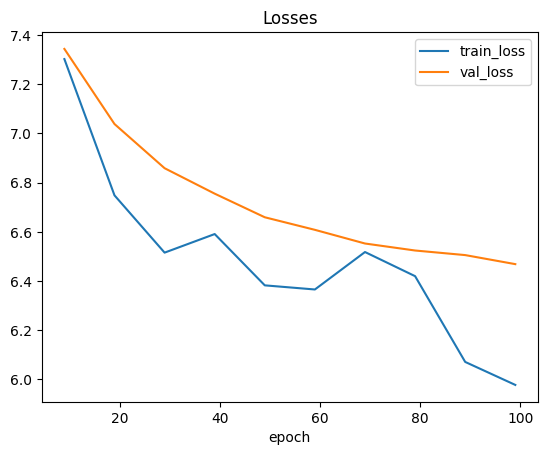

In [18]:
loss_df.plot(kind="line", x="epoch", title="Losses")

<Axes: title={'center': 'NDCG'}, xlabel='epoch'>

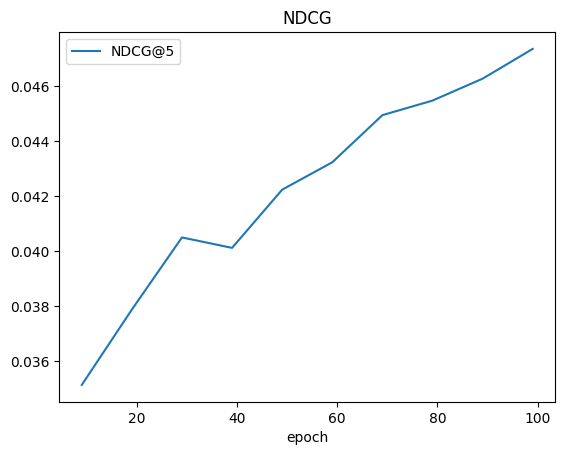

In [19]:
metrics_df[["epoch", "NDCG@5"]].plot(kind="line", x="epoch", title="NDCG")

In [20]:
user_counts = train_df['user_id'].value_counts()
TEST_USERS = user_counts[user_counts >= 3].index
recos = model.recommend(TEST_USERS, train_dataset, k=10, filter_viewed=False)
Recall(k=5).calc(reco=recos, interactions=test_df)

0.18361438439658676

In [ ]:
recos.to_pickle('/kaggle/working/lightning_logs/version_2/recos.pkl')

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **Экспорт модели**

In [ ]:
!zip -r version_2.zip /kaggle/working/lightning_logs/version_2

In [ ]:
from IPython.display import FileLink
FileLink(r'version_2.zip')